In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import librosa
from IPython.display import Audio 
from collections import defaultdict
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from numba import njit
from scipy.spatial.distance import pdist, squareform

In [2]:
X_train = np.load("RavdessAudioOnlyNumpy__X_train.npy")
X_test = np.load("RavdessAudioOnlyNumpy__X_test.npy")
y_train=pd.read_csv("RavdessAudioOnlyNumpy__Y_train.csv")
y_test=pd.read_csv("RavdessAudioOnlyNumpy__Y_test.csv")
X_train[np.isnan(X_train)] = 0
X_test[np.isnan(X_test)] = 0
X=np.vstack((X_train,X_test))
df=pd.DataFrame(X)

X_train_decimated = np.load("RavdessAudioOnlyNumpy__X_train_decimated.npy")
X_test_decimated = np.load("RavdessAudioOnlyNumpy__X_test_decimated.npy")
X_decimated=np.vstack((X_train_decimated,X_test_decimated))
df_decimated=pd.DataFrame(X_decimated)

X_train_decimated_scaled = np.load("RavdessAudioOnlyNumpy__X_train_decimated_scaled.npy")
X_test_decimated_scaled = np.load("RavdessAudioOnlyNumpy__X_test_decimated_scaled.npy")
X_decimated_scaled=np.vstack((X_train_decimated_scaled,X_test_decimated_scaled))
df_decimated_scaled=pd.DataFrame(X_decimated_scaled)

X_train_decimated_scaled_ft = np.load("RavdessAudioOnlyNumpy__X_train_decimated_scaled_ft.npy")
X_test_decimated_scaled_ft = np.load("RavdessAudioOnlyNumpy__X_test_decimated_scaled_ft.npy")
X_decimated_scaled_ft=np.vstack((X_train_decimated_scaled_ft,X_test_decimated_scaled_ft))
df_decimated_scaled_ft=pd.DataFrame(X_decimated_scaled_ft)

X_train_decimated_scaled_max = np.load("RavdessAudioOnlyNumpy__X_train_decimated_scaled_max.npy")
X_test_decimated_scaled_max = np.load("RavdessAudioOnlyNumpy__X_test_decimated_scaled_max.npy")
X_decimated_scaled_max = np.load("RavdessAudioOnlyNumpy__X_decimated_scaled_max.npy")
df_decimated_scaled_max=pd.DataFrame(X_decimated_scaled_max)

NOT USE WITH DECIMATED_SCALED_MAX: Clean the dataset (drop all the possible initial and final noise mantaining the same TSs length)

In [3]:
'''
#df_decimated_scaled_ft_denoised=df_decimated_scaled_ft[abs(df_decimated_scaled_ft)>0.1]
#X_decimated_scaled_ft_denoised=df_decimated_scaled_ft_denoised.values

firsts_notnan, lasts_notnan=[], []
for i in range(len(df_decimated_scaled)):
    #firsts_notnan.append((df_decimated_scaled_ft_denoised.iloc[i][np.isfinite(df_decimated_scaled_ft_denoised.iloc[i])]).index[0])
    #lasts_notnan.append((df_decimated_scaled_ft_denoised.iloc[i][np.isfinite(df_decimated_scaled_ft_denoised.iloc[i])]).index[-1])
    print(i)
    firsts_notnan.append(df_decimated_scaled.iloc[i][abs(df_decimated_scaled.iloc[i])>3.7].index[0])
    lasts_notnan.append(df_decimated_scaled.iloc[i][abs(df_decimated_scaled.iloc[i])>0.1].index[-1])

val_first_notnan=min(firsts_notnan)
first_notnan=np.argmin(firsts_notnan)
val_last_notnan=max(lasts_notnan)
last_notnan=np.argmax(lasts_notnan)
print(first_notnan, last_notnan)
print(val_first_notnan, val_last_notnan)
'''

'\n#df_decimated_scaled_ft_denoised=df_decimated_scaled_ft[abs(df_decimated_scaled_ft)>0.1]\n#X_decimated_scaled_ft_denoised=df_decimated_scaled_ft_denoised.values\n\nfirsts_notnan, lasts_notnan=[], []\nfor i in range(len(df_decimated_scaled)):\n    #firsts_notnan.append((df_decimated_scaled_ft_denoised.iloc[i][np.isfinite(df_decimated_scaled_ft_denoised.iloc[i])]).index[0])\n    #lasts_notnan.append((df_decimated_scaled_ft_denoised.iloc[i][np.isfinite(df_decimated_scaled_ft_denoised.iloc[i])]).index[-1])\n    print(i)\n    firsts_notnan.append(df_decimated_scaled.iloc[i][abs(df_decimated_scaled.iloc[i])>3.7].index[0])\n    lasts_notnan.append(df_decimated_scaled.iloc[i][abs(df_decimated_scaled.iloc[i])>0.1].index[-1])\n\nval_first_notnan=min(firsts_notnan)\nfirst_notnan=np.argmin(firsts_notnan)\nval_last_notnan=max(lasts_notnan)\nlast_notnan=np.argmax(lasts_notnan)\nprint(first_notnan, last_notnan)\nprint(val_first_notnan, val_last_notnan)\n'

In [4]:
'''
threshold=3.7
firsts_notnan=[]
for i in range(X_decimated_scaled.shape[0]):
    for j in range(X_decimated_scaled.shape[1]):
        if abs(X_decimated_scaled[i,j])>threshold:
            firsts_notnan.append(j)
            break
            
df_decimated_scaled_clean=df_decimated_scaled.iloc[:,val_first_notnan:val_last_notnan]
X_decimated_scaled_clean=df_decimated_scaled_clean.values
X_decimated_scaled_clean.shape

df_decimated_scaled.iloc[484].plot()
df_decimated_scaled_clean.iloc[484].plot()
plt.show()
'''

'\nthreshold=3.7\nfirsts_notnan=[]\nfor i in range(X_decimated_scaled.shape[0]):\n    for j in range(X_decimated_scaled.shape[1]):\n        if abs(X_decimated_scaled[i,j])>threshold:\n            firsts_notnan.append(j)\n            break\n            \ndf_decimated_scaled_clean=df_decimated_scaled.iloc[:,val_first_notnan:val_last_notnan]\nX_decimated_scaled_clean=df_decimated_scaled_clean.values\nX_decimated_scaled_clean.shape\n\ndf_decimated_scaled.iloc[484].plot()\ndf_decimated_scaled_clean.iloc[484].plot()\nplt.show()\n'

## Shape-based Clustering

Euclidean

In [5]:
from tslearn.clustering import TimeSeriesKMeans

In [6]:
X_decimated_scaled_max.shape

(2452, 50)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


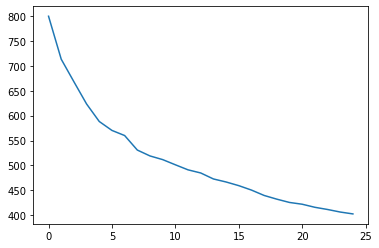

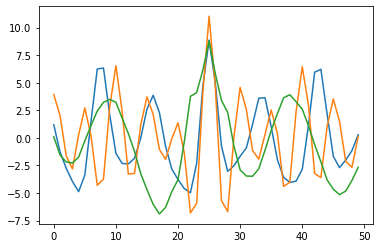

In [7]:

inertias_eucl=[]
for i in range(1,26):
    print(i)
    kmeans = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=15, random_state=0)
    kmeans.fit(X_decimated_scaled_max)
    inertias_eucl.append(kmeans.inertia_)
    
kmeans_centers= kmeans.cluster_centers_[:,:,0]
kmeans_centers[0].T
plt.plot(inertias_eucl)
plt.show()

plt.plot(kmeans_centers[0])
plt.plot(kmeans_centers[1])
plt.plot(kmeans_centers[2])
plt.show()


DTW

In [8]:
'''
inertias_dtw=[]
for i in range(1,26):
    print(i)
    kmeans = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=5, random_state=0)
    kmeans.fit(X_decimated_scaled_max)
    inertias_dtw.append(kmeans.inertia_)
    
kmeans_centers= kmeans.cluster_centers_[:,:,0]
kmeans_centers[0].T
plt.plot(inertias_dtw)
plt.show()

plt.plot(kmeans_centers[0])
plt.plot(kmeans_centers[1])
plt.plot(kmeans_centers[2])
plt.show()
'''

'\ninertias_dtw=[]\nfor i in range(1,26):\n    print(i)\n    kmeans = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=5, random_state=0)\n    kmeans.fit(X_decimated_scaled_max)\n    inertias_dtw.append(kmeans.inertia_)\n    \nkmeans_centers= kmeans.cluster_centers_[:,:,0]\nkmeans_centers[0].T\nplt.plot(inertias_dtw)\nplt.show()\n\nplt.plot(kmeans_centers[0])\nplt.plot(kmeans_centers[1])\nplt.plot(kmeans_centers[2])\nplt.show()\n'

In [9]:
#np.save("inertias_dtw.npy",inertias_dtw)

Sakoe-Chiba Kmeans with DTW

In [10]:
from joblib import Parallel, delayed

@njit
def dtw_distance(x, y, window):
    # Calculate the DTW distance between two sequences with Sakoe-Chiba band constraint
    x_len, y_len = len(x), len(y)
    window = max(window, abs(x_len - y_len))
    dtw_matrix = np.zeros((x_len + 1, y_len + 1))
    dtw_matrix[0, 1:] = np.inf
    dtw_matrix[1:, 0] = np.inf

    for i in range(1, x_len + 1):
        for j in range(max(1, i - window), min(y_len, i + window) + 1):
            cost = abs(x[i - 1] - y[j - 1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i - 1, j], dtw_matrix[i, j - 1], dtw_matrix[i - 1, j - 1])

    return dtw_matrix[-1, -1]

def calculate_distances(data, centroids, window):
    # Calculate distances between samples and centroids
    return cdist(data, centroids, metric=lambda x, y: dtw_distance(x, y, window))

def kmeans_with_sakoe_chiba(data, k, window, max_iterations):
    n_samples = data.shape[0]
    centroids = data[np.random.choice(n_samples, k, replace=False)]
    iteration = 0

    while iteration < max_iterations:
        # Calculate distances between samples and centroids
        distances = calculate_distances(data, centroids, window)

        # Assign labels based on minimum distance
        labels = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = Parallel(n_jobs=-1)(
            delayed(np.mean)(data[labels == i], axis=0) for i in range(k)
        )
        new_centroids = np.vstack(new_centroids)

        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids
        iteration += 1

    # Calculate inertia
    inertia = np.sqrt(np.min(distances, axis=1).sum())

    return centroids, labels, inertia


In [11]:
'''
inertias_dtw_sc=[]
for i in range(1,51,5):
    _, _, inertia = kmeans_with_sakoe_chiba(X_decimated_scaled_max, k=12, window=i, max_iterations=5)
    inertias_dtw_sc.append(inertia)

plt.plot(np.arange(1,51,5),inertias_dtw_sc)
plt.show()
'''

'\ninertias_dtw_sc=[]\nfor i in range(1,51,5):\n    _, _, inertia = kmeans_with_sakoe_chiba(X_decimated_scaled_max, k=12, window=i, max_iterations=5)\n    inertias_dtw_sc.append(inertia)\n\nplt.plot(np.arange(1,51,5),inertias_dtw_sc)\nplt.show()\n'

In [12]:
#np.save("inertias_dtw_sc.npy",inertias_dtw_sc)

In [24]:
i=np.load("inertias_dtw.npy")
i

array([335.94187044, 292.86232208, 271.96522767, 257.05596104,
       246.13734003, 238.87489782, 225.42045756, 218.22367662,
       213.87171698, 210.11042201, 206.81285467, 203.36164709,
       196.18017499, 193.65289281, 191.16149712, 187.1041875 ,
       185.17970996, 183.61835516, 181.59758711, 180.94310853,
       175.97596424, 174.74699315, 172.11384236, 170.95236341,
       169.22838176])

## DBSCAN

In [14]:
from sklearn.cluster import DBSCAN
from kneed import KneeLocator

In [15]:
# Define a function to compute the DTW distance between two time series subsequences
@njit
def dtw_distance(x, y):
    # Calculate the DTW distance between two sequences
    x_len, y_len = len(x), len(y)
    dtw_matrix = np.zeros((x_len + 1, y_len + 1))
    dtw_matrix[0, 1:] = 0
    dtw_matrix[1:, 0] = 0

    for i in range(1, x_len + 1):
        for j in range(1, y_len + 1):
            cost = abs(x[i - 1] - y[j - 1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i - 1, j], dtw_matrix[i, j - 1], dtw_matrix[i - 1, j - 1])

    return dtw_matrix[-1, -1]

# Compute the pairwise distances between time series subsequences in parallel
def distance(subseqs, metric):
    if metric == "euclidean":
        return np.linalg.norm(subseqs[:, None] - subseqs, axis=-1, ord=2)/100
    elif metric == "dtw":
        dist_matrix = np.full((len(subseqs), len(subseqs)), 0)
        for i in range(len(subseqs)):
            for j in range(i + 1, len(subseqs)):
                dist_matrix[i, j] = dtw_distance(subseqs[i], subseqs[j])
                dist_matrix[j, i] = dist_matrix[i, j]
        return dist_matrix/100

def TimeSeriesDBSCAN(data, epsilon, min_samples, metric):
    dist_matrix = distance(data, metric)

    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='precomputed')
    clusters = dbscan.fit_predict(dist_matrix)
    labels = dbscan.labels_
    silhouette = silhouette_score(data, labels)

    # Print the cluster labels
    return labels, clusters, silhouette

In [16]:
dist_dtw = distance(X_decimated_scaled_max, 'dtw')
dist_eucl = distance(X_decimated_scaled_max, 'euclidean')

In [17]:
k=5
kth_distances_dtw = []
for d in dist_dtw:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances_dtw.append(d[index_kth_distance])  # store the distance in a list

kth_distances_eucl = []
for d in dist_eucl:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances_eucl.append(d[index_kth_distance])  # store the distance in a list

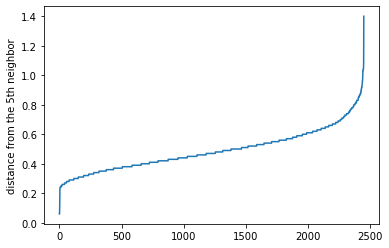

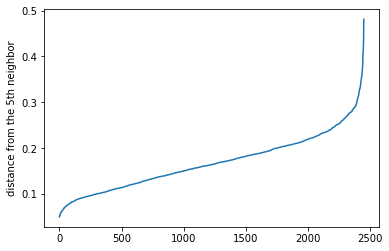

In [18]:
plt.plot(range(0, len(kth_distances_dtw)), sorted(kth_distances_dtw))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()

plt.plot(range(0, len(kth_distances_eucl)), sorted(kth_distances_eucl))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()

In [19]:
#dtw
labels, clusters, silhouette = TimeSeriesDBSCAN(data=X_decimated_scaled_max, epsilon=0.8, min_samples=k, metric="dtw")

In [20]:
np.unique(labels, return_counts=True), clusters, silhouette

((array([-1,  0]), array([  21, 2431])),
 array([0, 0, 0, ..., 0, 0, 0]),
 0.345603435878155)

In [21]:
#euclidean
labels, clusters, silhouette = TimeSeriesDBSCAN(data=X_decimated_scaled_max, epsilon=0.25, min_samples=k, metric="euclidean")

In [23]:
np.unique(labels, return_counts=True), clusters, silhouette

((array([-1,  0]), array([  86, 2366])),
 array([0, 0, 0, ..., 0, 0, 0]),
 0.28779092439537174)